In [1]:
import sys
sys.path.append('../src')
#import torch
from semantic_bac_segment.models.pytorch_altmodel import UNET
#from semantic_bac_segment.models.pytorch_attention import AttentionUNet

#unet=UNET()
#model_path='../data/models/state_weights/unet_model_expandedmask_7_best_model.pth'
#model_path='../data/models/state_weights/unet_model_expandedmask_attention_12_best_model.pth'
#unet.from_pretrained(model_path)



KeyboardInterrupt: 

In [ ]:
import torch
from semantic_bac_segment.utils import get_device, normalize_percentile, empty_gpu_cache
from monai.inferers import SlidingWindowInferer
import gc

class Segmentator3:
    """
    A class representing a segmentation model.

    Attributes:
        model (torch.nn.Module): The segmentation model.
        device (torch.device): The device on which the model is loaded.
    """

    def __init__(self, model_path, model_graph, patch_size, overlap_ratio, half_precision=False):
        """
        Initializes a Segmentator object.

        Args:
            model_path (str): The path to the model.
            model_graph (str): The model graph.
            patch_size (int): The size of the patches.
            overlap_ratio (float): The overlap ratio between patches.
        """
        self.device = get_device()
        self.model = self.get_model(model_path, self.device, model_graph=model_graph)
        self.patch_size = patch_size
        self.overlap_ratio = overlap_ratio
        self.model.eval()
        self.half_precision=half_precision
        if self.half_precision:
            self.model.half()  


    def predict(self, image):
        """
        Predicts the segmentation mask for the given image. It can handle 2D images or a stack of 2D images.

        Args:
            image (numpy.ndarray): The input image or image stack.

        Returns:
            numpy.ndarray: The segmentation mask or stack of segmentation masks.
        """
        
        # Normalize image
        image = normalize_percentile(image)

        # Check if the image is a stack
        if len(image.shape) > 2:
            # Store the original image size and number of slices
            original_size = image.shape[1:]
            num_slices = image.shape[0]

            # Convert the entire stack to a tensor and add batch dimension
            img_tensor = torch.from_numpy(image).unsqueeze(1).to(self.device)  # Shape: [1, C, H, W]
            if self.half_precision:
                img_tensor = img_tensor.half()  # Convert input to half-precision

            # Create SlidingWindowInferer
            inferer = SlidingWindowInferer(roi_size=self.patch_size, sw_batch_size=1, overlap=self.overlap_ratio, BlendMode = "gaussian")

            with torch.no_grad():
                output_mask = inferer(img_tensor, self.model)
                output_mask = torch.sigmoid(output_mask)
            output_mask = output_mask.cpu().numpy()  # Remove batch dimension

            # Split the result back into the original chunks
            #output_mask = np.dsplit(output_mask, num_slices)

        else:
            # Process the image as before
            img_tensor = torch.from_numpy(image).unsqueeze(0).to(self.device)

            if self.half_precision:
                img_tensor = img_tensor.half()  # Convert input to half-precision

            # Create SlidingWindowInferer
            inferer = SlidingWindowInferer(roi_size=self.patch_size, sw_batch_size=350, overlap=self.overlap_ratio)

            with torch.no_grad():
                output_mask = inferer(img_tensor, self.model)

            output_mask = output_mask.squeeze(0).squeeze(0).cpu().numpy()

            # Free up tensors
            del img_tensor, image  
            gc.collect() 
            empty_gpu_cache(self.device)

        return output_mask
   

    def get_model(self, path, device, model_graph=None):
        """
        Loads a model from the specified path and returns it.

        Args:
            path (str): The path to the model file.
            device (str): The device to load the model onto.
            model_graph (Optional[torch.nn.Module]): An optional pre-initialized model graph.

        Returns:
            torch.nn.Module: The loaded model.

        Raises:
            FileNotFoundError: If the model file is not found at the specified path.
            RuntimeError: If an error occurs while loading the model.
            Exception: If an unexpected error occurs.
        """
        try:
            if model_graph is None:
                model = torch.load(path, map_location=device)
            else:
                model = model_graph
                state_dict = torch.load(path, map_location=device)
                
                # Check if the loaded state dictionary is compatible with the model architecture
                if not set(state_dict.keys()).issubset(set(model.state_dict().keys())):
                    raise ValueError("Loaded state dictionary does not match the model architecture.")
                
                model.load_state_dict(state_dict)
            
            model.to(device)
            torch.compile(model, mode = 'max-autotune')
            
            return model
        
        except FileNotFoundError:
            raise FileNotFoundError(f"Model file not found at path: {path}")
        
        except RuntimeError as e:
            raise RuntimeError(f"Error occurred while loading the model: {str(e)}")
        
        except Exception as e:
            raise Exception(f"Unexpected error occurred: {str(e)}")

In [ ]:
from semantic_bac_segment.segmentator import Segmentator
from semantic_bac_segment.model_loader import model_loader
from semantic_bac_segment.utils import get_device
from monai.networks.nets import UNet as monai_unet
from semantic_bac_segment.models.pytorch_cnnunet import Unet as atomai_unet
from monai.networks.nets import (
    UNETR,
    AHNet,
    DynUNet,

    )
import json
#model_path='../data/models/state_weights/unet_model_expandedmask_17_-leakyrelu-16-128features-sigmoid-256-dropout_best_model.pth'
#model_path='../results/MonaiUnet-1_best_model.pth'
model_path='../results/atomai_unet-3class-3_best_model.pth'

with open('../results/atomai_unet-3class-3_best_config.json') as jfile:
    model_param = json.load(jfile)
#model=Unet(nb_classes=3, nb_filters=32)
bac_seg_monai=Segmentator(model_path, atomai_unet(**model_param['model_args']), patch_size=256, overlap_ratio=0.25, half_precision=True)




Exception: Unexpected error occurred: "filename 'storages' not found"

In [ ]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


/var/folders/l9/mzf3xz016nn449t2nlqp0k680000gn/T/ipykernel_4072/2556829709.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


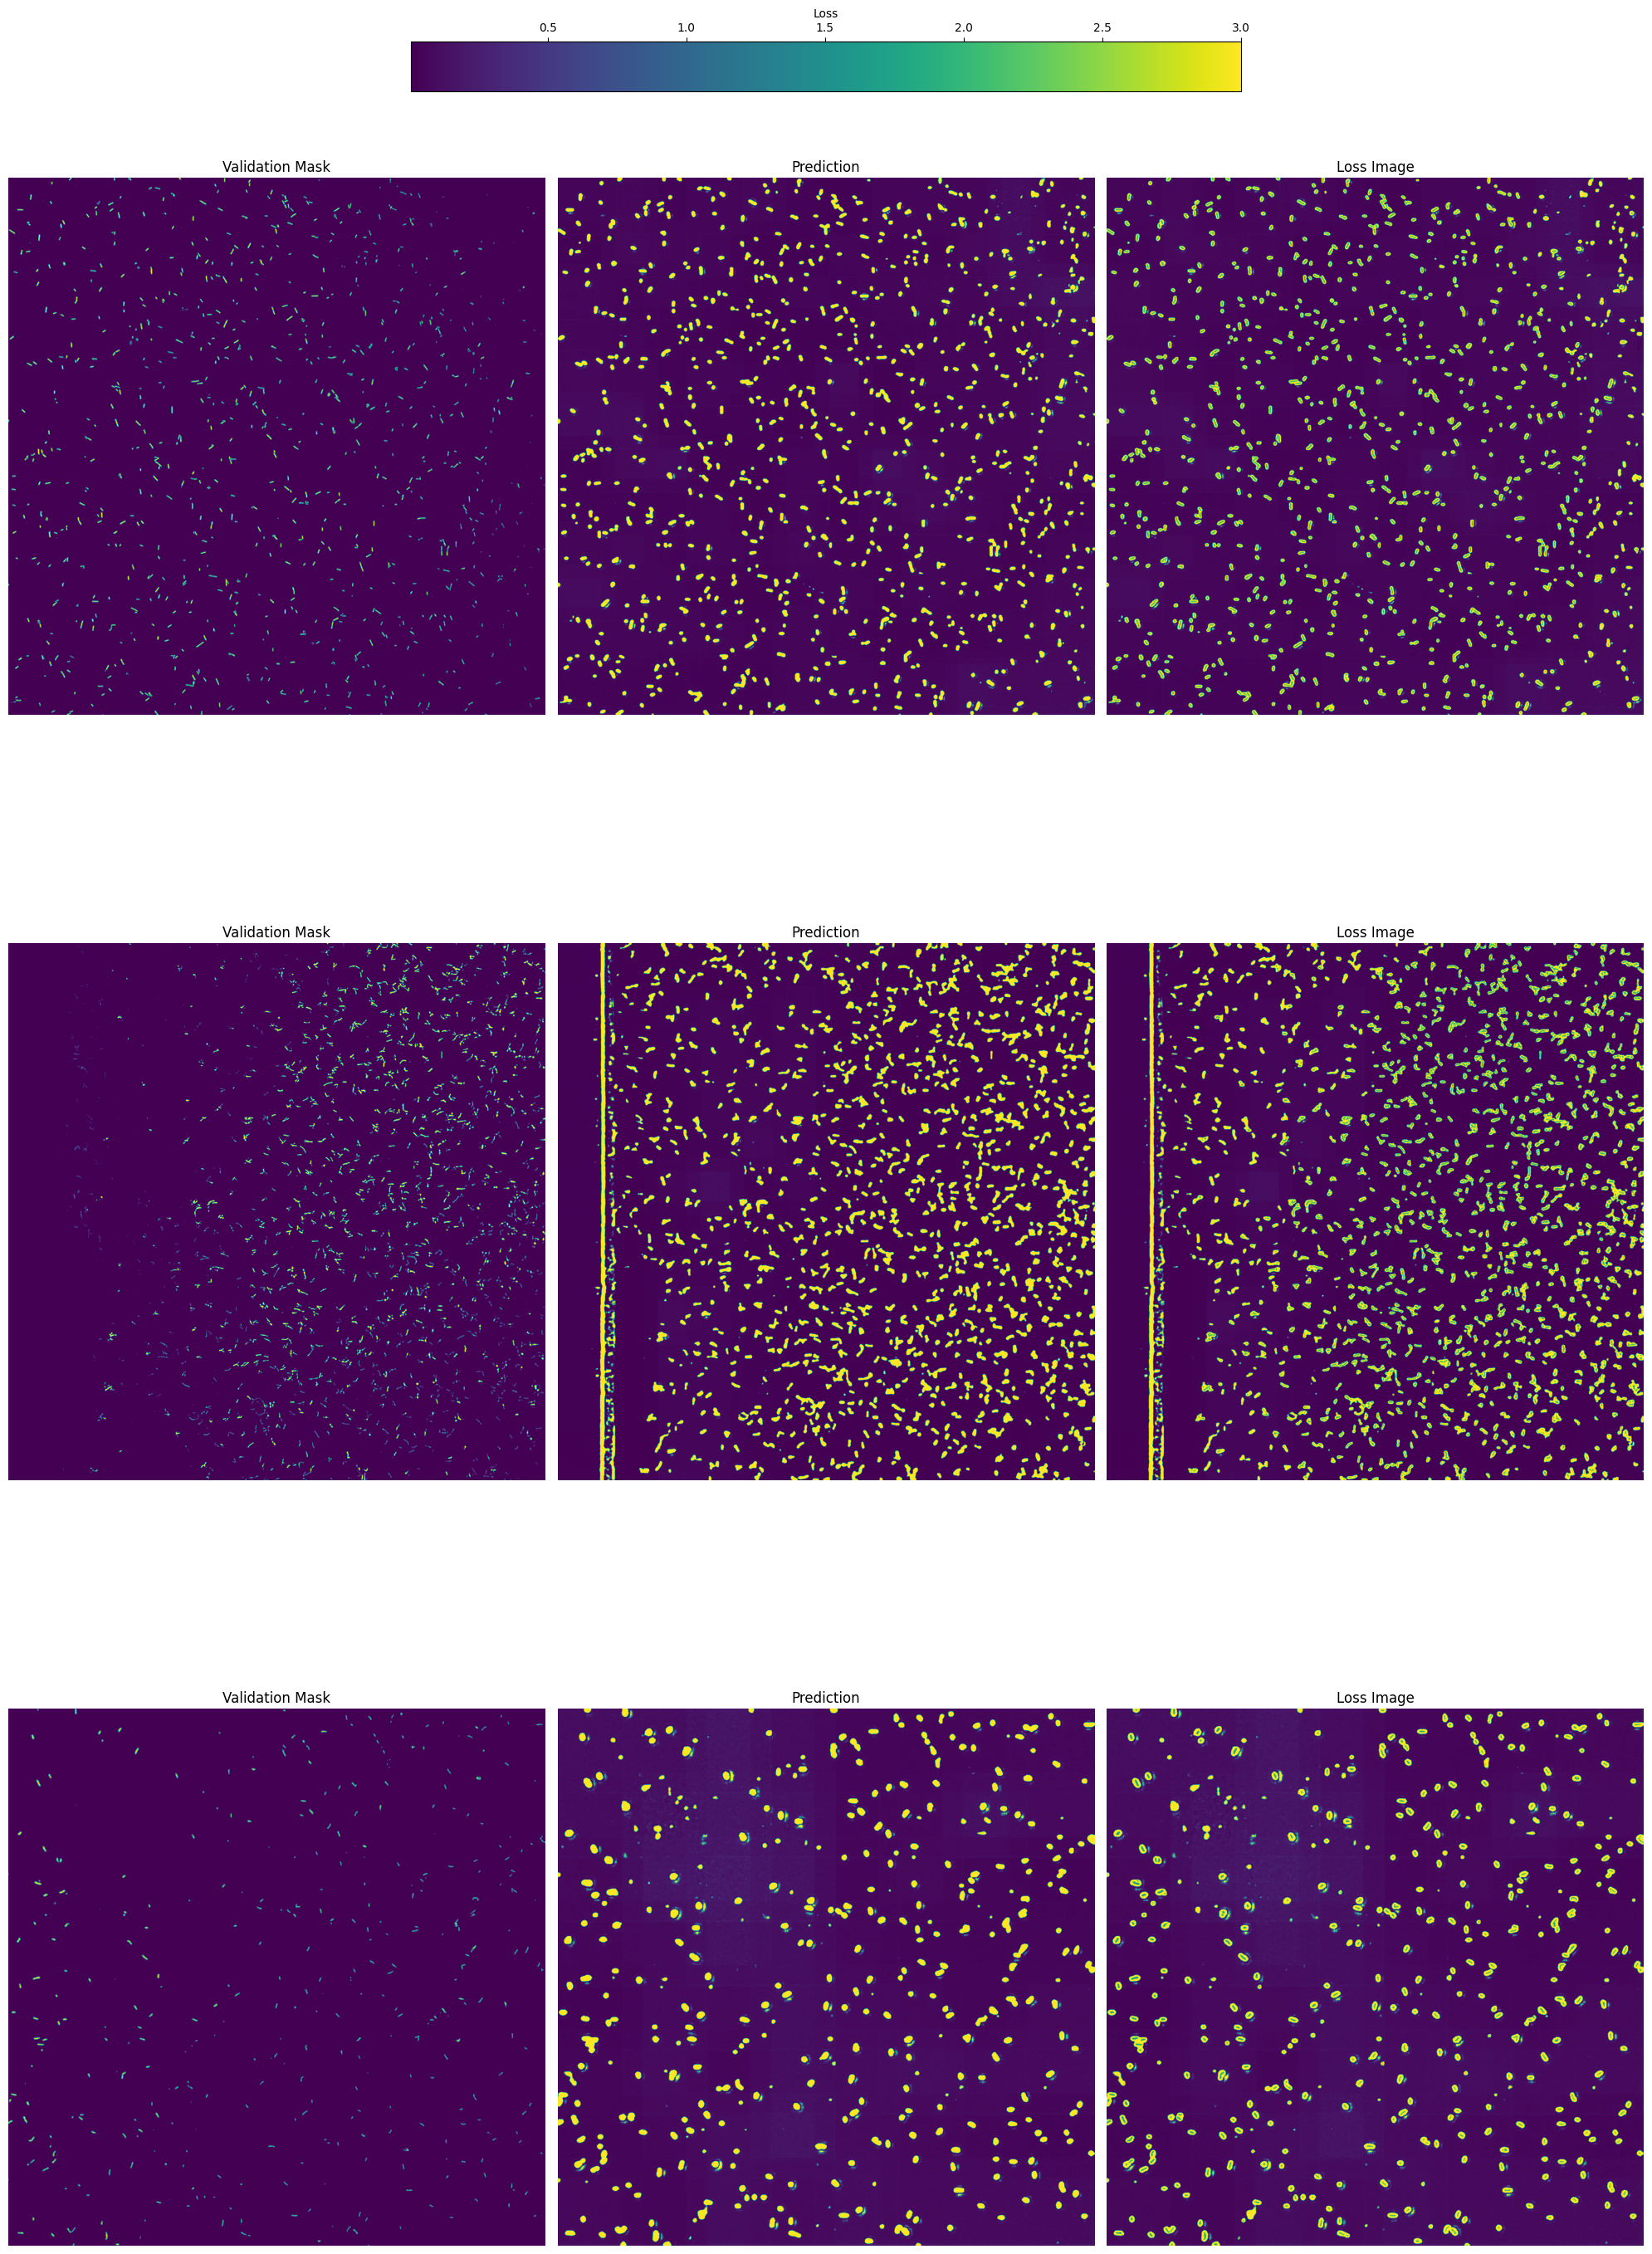

In [ ]:
from semantic_bac_segment.utils import normalize_percentile

import matplotlib.pyplot as plt
import tifffile
import numpy as np

def plot_image_grid(image_list, bac_seg_monai):
    num_images = len(image_list)
    fig, axes = plt.subplots(num_images, 3, figsize=(20, 10 * num_images))
    fig.subplots_adjust(top=0.9)  # Adjust the top spacing for the colorbar

    for i, image in enumerate(image_list):
        img = tifffile.imread(f'../data/source_norm/{image}.tiff')
        predicted_imgs = bac_seg_monai.predict(img)
        predicted_imgs=sigmoid(predicted_imgs)
        if predicted_imgs.ndim ==3: 
            predicted_imgs=np.sum(predicted_imgs , axis=0)
        mask = tifffile.imread(f'../data/masks_cleaned/{image}.tiff')
        mask = normalize_percentile(mask)
        loss_image = np.abs(mask - predicted_imgs)

        # Plot the validation mask
        axes[i, 0].imshow(mask/255)
        axes[i, 0].set_title('Validation Mask')
        axes[i, 0].axis('off')

        # Plot the prediction image
        axes[i, 1].imshow(predicted_imgs)
        axes[i, 1].set_title('Prediction')
        axes[i, 1].axis('off')

        # Plot the loss image
        im = axes[i, 2].imshow(loss_image)
        axes[i, 2].set_title('Loss Image')
        axes[i, 2].axis('off')

    # Create a new axes object for the colorbar
    cbar_ax = fig.add_axes([0.25, 0.95, 0.5, 0.02])  # [left, bottom, width, height]
    cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
    cbar.ax.xaxis.set_ticks_position('top')  # Set the tick position to the top
    cbar.ax.xaxis.set_label_position('top')  # Set the label position to the top
    cbar.set_label('Loss')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()

# Example usage
image_list = ["coli_mask_frame_132", "mabs_img_34", "mabs_img_35"]
plot_image_grid(image_list, bac_seg_monai)


In [12]:

from semantic_bac_segment.utils import convert_image
import numpy as np
import glob
import os

input_folder='../data/source_norm/'
output_folder='../data/predictions_check3'
list_images = glob.glob('../data/source_norm/*.tiff')


for n, image_i in enumerate(list_images):
    print(f'image number {n + 1} of {len(list_images)}')
    img=tifffile.imread(image_i)
    predicted_imgs= bac_seg_monai.predict(img)
    predicted_imgs=sigmoid(predicted_imgs)

    if predicted_imgs.ndim == 3:
        predicted_imgs=np.sum(predicted_imgs , axis=0)

    predicted_imgs=convert_image(predicted_imgs*255, np.uint8)
    tifffile.imwrite(os.path.join(output_folder,os.path.basename(image_i)), predicted_imgs)


image number 1 of 47


/var/folders/l9/mzf3xz016nn449t2nlqp0k680000gn/T/ipykernel_62544/638571445.py:4: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


image number 2 of 47
image number 3 of 47
image number 4 of 47
image number 5 of 47
image number 6 of 47
image number 7 of 47
image number 8 of 47
image number 9 of 47
image number 10 of 47
image number 11 of 47
image number 12 of 47
image number 13 of 47
image number 14 of 47
image number 15 of 47
image number 16 of 47
image number 17 of 47
image number 18 of 47
image number 19 of 47
image number 20 of 47
image number 21 of 47
image number 22 of 47
image number 23 of 47
image number 24 of 47
image number 25 of 47
image number 26 of 47
image number 27 of 47
image number 28 of 47
image number 29 of 47
image number 30 of 47
image number 31 of 47
image number 32 of 47
image number 33 of 47
image number 34 of 47
image number 35 of 47
image number 36 of 47
image number 37 of 47
image number 38 of 47
image number 39 of 47
image number 40 of 47
image number 41 of 47
image number 42 of 47
image number 43 of 47
image number 44 of 47
image number 45 of 47
image number 46 of 47
image number 47 of

In [41]:
import os
import json

dir_models='../data/models/state_weights/'

def list_files_with_pattern(directory, pattern):
    pth_files = []
    json_files = []

    for filename in os.listdir(directory):
        if pattern in filename:
            if filename.endswith('.pth'):
                pth_files.append(filename)
            elif filename.endswith('.json'):

                with open(os.path.join(directory, filename)) as f:
                    json_files.append(json.load(f))

    return pth_files, json_files

models, metadata= list_files_with_pattern(dir_models, '-4-128')

In [16]:
from semantic_bac_segment.loss_functions import DiceLoss, MultiClassDiceLoss
from semantic_bac_segment.utils import normalize_percentile, tensor_debugger
from semantic_bac_segment.segmentator import Segmentator3
import os
import time
# Image sources
input_folder='../data/source_norm/'
output_folder='../data/predictions_check'
list_images=os.listdir('../data/source_norm/')
mask_folder='../data/multiclass_masks3class/'
alex_predictions='/Volumes/Transfer$/transfer/Lab_305/Santi/Santi_Outputfiles_PCfeatures_PCh5/cross_val_stack_bf_data/stack_to_slices/'

# Compare models
"""
model_list=['unet_model_test_2_best_model.pth',
            'unet_model_test_4_best_model.pth',
            'unet_model_expandedmask_16_weighted-leakyrelu_best_model.pth',
            'unet_model_expandedmask_15_weighteddice_best_model.pth',
            'unet_model_expandedmask_9_best_model.pth',
            'unet_model_expandedmask_8_best_model.pth',
            'unet_model_expandedmask_7_best_model.pth',
            'unet_model_expandedmask_12_attention_best_model.pth',
            'unet_model_expandedmask_13_best_model.pth',
            'unet_model_expandedmask_14_attention_best_model.pth'
            ]
dir_models='../data/models/state_weights/'
"""
dir_models=""
#model_list=['unet_model_expandedmask_7_best_model.pth']
criterion=DiceLoss()
models=['Alex_pmaps']
metadata={
    'Alex_pmaps':{
        'model_params':{'features':1},
        'optimizer_params':{'model_name':'Alex'}
    }
}
results=[]
for model_i, metadata_i in zip(models, metadata):
    #features=metadata_i['model_params']['features']
    #model_i=metadata_i['optimizer_params']['model_name']+'_best_model.pth'
    print(f'image number {model_i} of {len(models)}')
    model_i_path = os.path.join(dir_models, model_i)

#    if 'attention' in model_i:
#
#        bac_seg_monai=Segmentator3(model_i_path, AttentionUNet(), patch_size=128, overlap_ratio=0.10, half_precision=True)
#    else:
#        bac_seg_monai=Segmentator3(model_i_path, UNET(features=features), patch_size=256, overlap_ratio=0.10, half_precision=True)

    for n, i in enumerate(list_images):

        if ".tiff" in i:
            print(f'analysing image {i}')
            print(f'image number {n + 1} of {len(list_images)}')
            image_path=os.path.join(input_folder, i)
            mask_path=os.path.join(mask_folder, i)
            alex_img_path=os.path.join(alex_predictions, i)

            img=tifffile.imread(image_path)
            mask=tifffile.imread(mask_path)
            #predicted_imgs = tifffile.imread(alex_img_path)
            mask=normalize_percentile(mask)
            start_time = time.time()

            predicted_imgs= bac_seg_monai.predict(img)
            predicted_imgs=sigmoid(predicted_imgs)
            
            end_time = time.time()
            prediction_time = end_time - start_time
            torch_masks=torch.from_numpy(mask)
            torch_pred=torch.from_numpy(predicted_imgs)

            loss=criterion(torch.max(torch_masks, dim =0)[0], 
                        torch.max(torch_pred, dim =0)[0])
                
            loss_value=loss.item()
            print(loss_value)
            results.append({'Model': model_i, 'Image': i, 'Dice Loss': loss_value, 'Prediction Time': prediction_time})



image number Alex_pmaps of 1
analysing image coli_mask_frame_205.tiff
image number 1 of 48


/var/folders/l9/mzf3xz016nn449t2nlqp0k680000gn/T/ipykernel_9051/638571445.py:4: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


0.3962627649307251
analysing image mabs_img_13.tiff
image number 2 of 48
0.14300549030303955
analysing image mabs_img_05.tiff
image number 3 of 48
0.23796337842941284
analysing image mabs_img_29.tiff
image number 4 of 48
0.26047706604003906
analysing image mabs_img_09.tiff
image number 5 of 48
0.32354676723480225
analysing image mabs_img_25.tiff
image number 6 of 48
0.21463799476623535
analysing image mabs_img_33.tiff
image number 7 of 48
0.19030439853668213
analysing image coli_mask_frame_1.tiff
image number 8 of 48
0.13337212800979614
analysing image mabs_img_32.tiff
image number 9 of 48
0.3981645703315735
analysing image coli_mask_frame_232.tiff
image number 10 of 48
0.15234190225601196
analysing image mabs_img_24.tiff
image number 12 of 48
0.16313022375106812
analysing image mabs_img_08.tiff
image number 13 of 48
0.24699509143829346
analysing image coli_mask_frame_101.tiff
image number 14 of 48
0.7642155289649963
analysing image mabs_img_28.tiff
image number 15 of 48
0.336628019809

In [4]:
import pandas as pd
df = pd.DataFrame(results)


NameError: name 'results' is not defined

In [17]:
df.to_csv("../data/model_analysis/alex_pmaps.csv")

In [5]:
df = pd.read_csv("../data/model_analysis/alex_pmaps.csv")

In [2]:
import pandas as pd
combined_results= pd.read_csv("../data/model_analysis/model_performance_combined.csv")

In [7]:
df=pd.concat([combined_results, df ], axis=0)

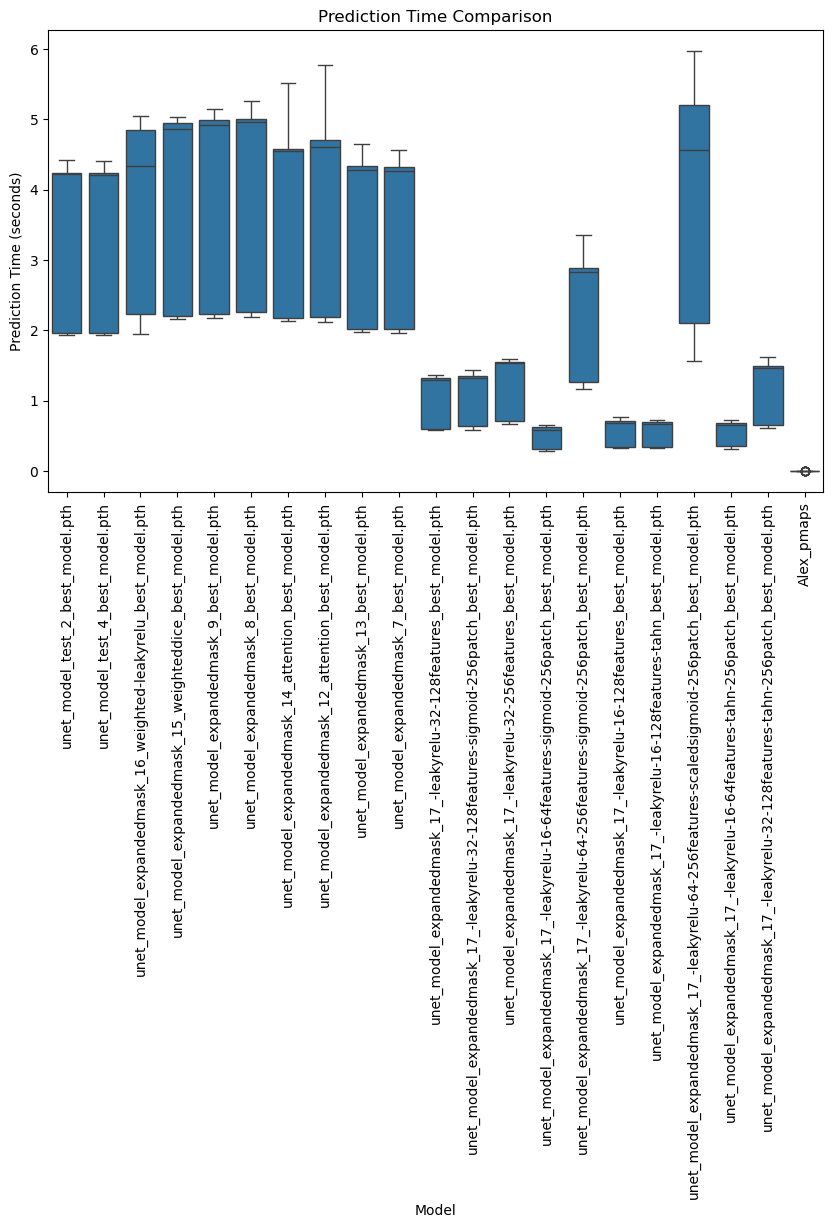

Model Summary:
                                                Model  Dice Loss  \
0                                          Alex_pmaps   0.602858   
1   unet_model_expandedmask_12_attention_best_mode...   0.980247   
2           unet_model_expandedmask_13_best_model.pth   0.366155   
3   unet_model_expandedmask_14_attention_best_mode...   0.349129   
4   unet_model_expandedmask_15_weighteddice_best_m...   0.631687   
5   unet_model_expandedmask_16_weighted-leakyrelu_...   0.634664   
6   unet_model_expandedmask_17_-leakyrelu-16-128fe...   0.420337   
7   unet_model_expandedmask_17_-leakyrelu-16-128fe...   0.338816   
8   unet_model_expandedmask_17_-leakyrelu-16-64fea...   0.335506   
9   unet_model_expandedmask_17_-leakyrelu-16-64fea...   0.480930   
10  unet_model_expandedmask_17_-leakyrelu-32-128fe...   0.424141   
11  unet_model_expandedmask_17_-leakyrelu-32-128fe...   0.405662   
12  unet_model_expandedmask_17_-leakyrelu-32-128fe...   0.378829   
13  unet_model_expandedmask_17_-l

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create a boxplot of prediction times for each model using Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='Prediction Time', data=df)
plt.xlabel('Model')
plt.xticks(rotation=90)
plt.ylabel('Prediction Time (seconds)')
plt.title('Prediction Time Comparison')
plt.show()

# Calculate average prediction time and accuracy for each model
model_summary = df.groupby('Model').agg({'Dice Loss': 'mean', 'Prediction Time': 'mean'}).reset_index()
print("Model Summary:")
print(model_summary)


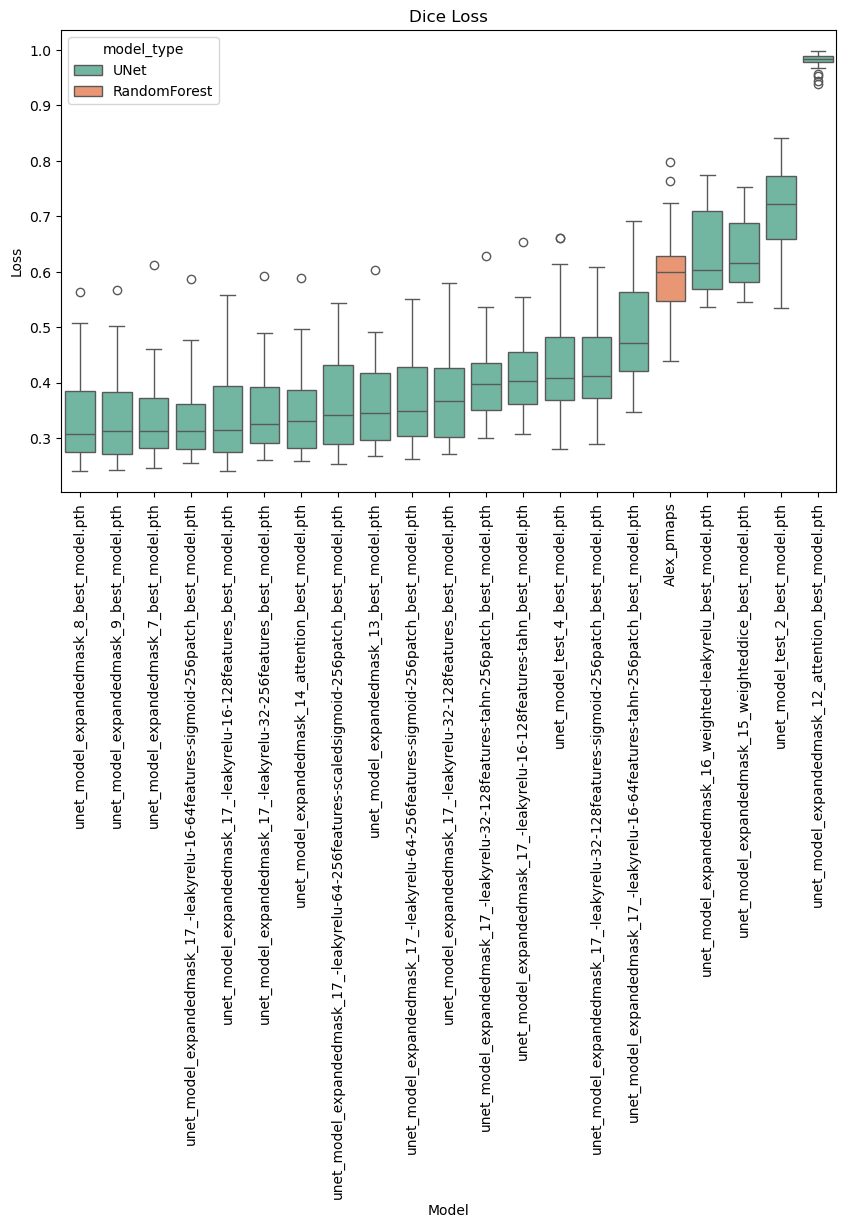

In [10]:
# Create a boxplot of prediction times for each model using Seaborn
# Group by model and calculate median
medians = df.groupby('Model')['Dice Loss'].median()
df['model_type'] = df['Model'].apply(lambda x: 'RandomForest' if x == 'Alex_pmaps' else 'UNet')

# Sort df by these median values
df['Median'] = df['Model'].map(medians)
sorted_df = df.sort_values('Median')

# Drop the temporary 'Median' column
sorted_df = sorted_df.drop(columns='Median')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='Dice Loss', data=sorted_df, hue='model_type', palette='Set2')
plt.xlabel('Model')
plt.xticks(rotation=90)
plt.ylabel('Loss')
plt.title('Dice Loss')
plt.show()



/var/folders/l9/mzf3xz016nn449t2nlqp0k680000gn/T/ipykernel_9425/3303830372.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mabs_df['Median'] = mabs_df['Model'].map(medians)


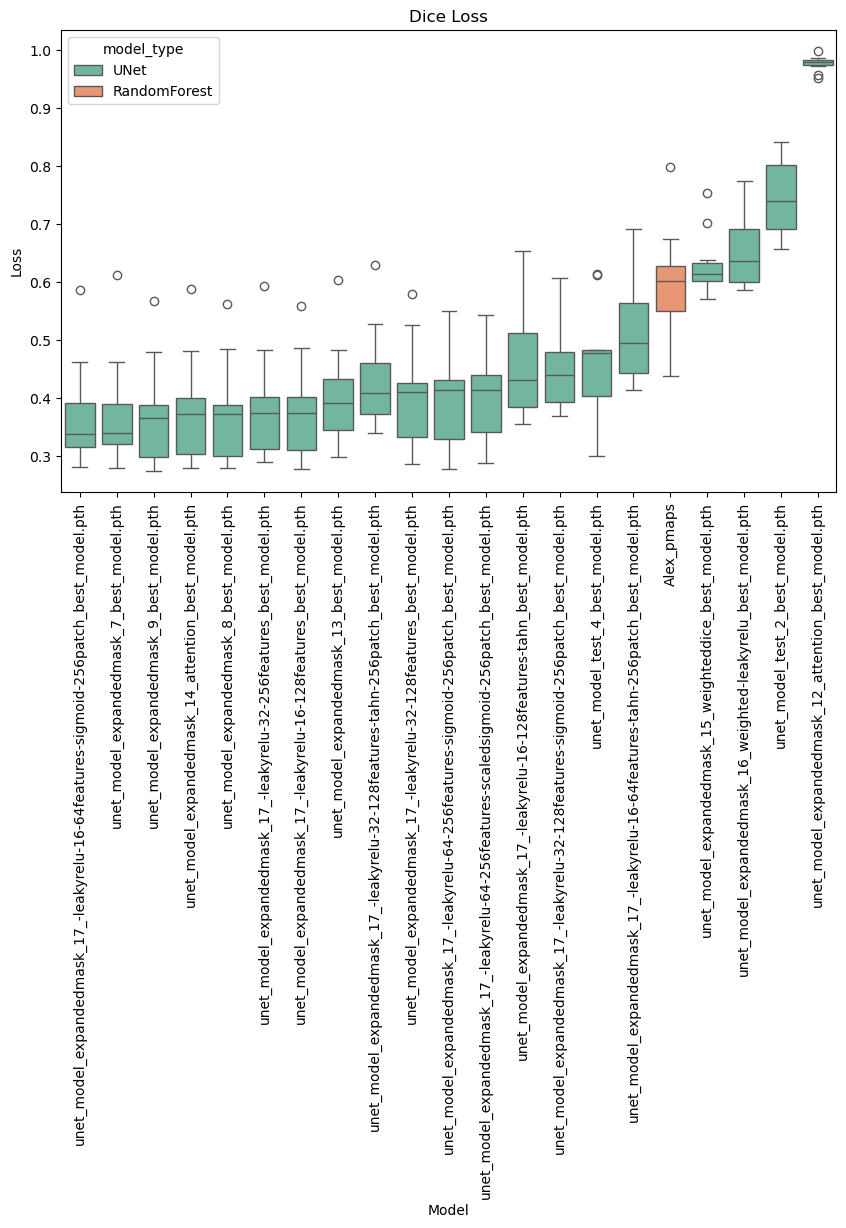

In [14]:
# Create a boxplot of prediction times for each model using Seaborn
# Group by model and calculate median

mabs_df = df[df['Image'].str.contains('mabs')]

medians = mabs_df.groupby('Model')['Dice Loss'].median()

# Sort df by these median values
mabs_df['Median'] = mabs_df['Model'].map(medians)
sorted_df = mabs_df.sort_values('Median')

# Drop the temporary 'Median' column
sorted_df = sorted_df.drop(columns='Median')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='Dice Loss', data=sorted_df, hue='model_type', palette='Set2')
plt.xlabel('Model')
plt.xticks(rotation=90)
plt.ylabel('Loss')
plt.title('Dice Loss')
plt.show()

In [55]:
# Calculate mean and standard deviation for Dice Loss and Prediction Time
model_summary = df.groupby('Model').agg({'Dice Loss': ['mean', 'std'], 'Prediction Time': ['mean', 'std']}).reset_index()
model_summary.columns = ['Model', 'Dice Loss Mean', 'Dice Loss Std', 'Prediction Time Mean', 'Prediction Time Std']
model_summary['Dice Loss Std'] /= np.sqrt(31)
model_summary['Prediction Time Std'] /= np.sqrt(31)

# Create a new column 'Formatted Name' with line breaks
model_summary['Formatted Name'] = model_summary['Model'].str.replace('_', '\n')


/var/folders/l9/mzf3xz016nn449t2nlqp0k680000gn/T/ipykernel_17415/2442840622.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0.2, 1, 1])


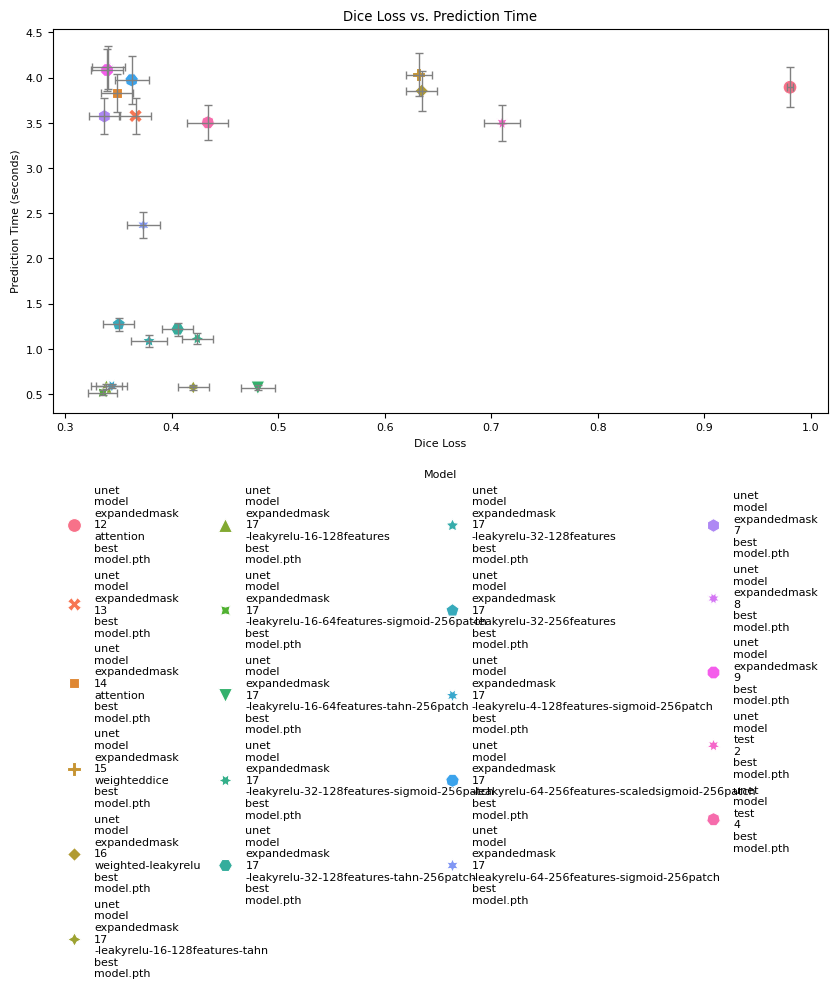

Model Summary:
                                                Model  Dice Loss Mean  \
0   unet_model_expandedmask_12_attention_best_mode...        0.980247   
1           unet_model_expandedmask_13_best_model.pth        0.366155   
2   unet_model_expandedmask_14_attention_best_mode...        0.349129   
3   unet_model_expandedmask_15_weighteddice_best_m...        0.631687   
4   unet_model_expandedmask_16_weighted-leakyrelu_...        0.634664   
5   unet_model_expandedmask_17_-leakyrelu-16-128fe...        0.420337   
6   unet_model_expandedmask_17_-leakyrelu-16-128fe...        0.338816   
7   unet_model_expandedmask_17_-leakyrelu-16-64fea...        0.335506   
8   unet_model_expandedmask_17_-leakyrelu-16-64fea...        0.480930   
9   unet_model_expandedmask_17_-leakyrelu-32-128fe...        0.424141   
10  unet_model_expandedmask_17_-leakyrelu-32-128fe...        0.405662   
11  unet_model_expandedmask_17_-leakyrelu-32-128fe...        0.378829   
12  unet_model_expandedmask_17_-leak

In [56]:
# Create a scatter plot of Dice Loss vs. Prediction Time, colored by model, with error bars
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Dice Loss Mean', y='Prediction Time Mean', data=model_summary, hue='Formatted Name', style='Formatted Name', s=100)
plt.errorbar(x=model_summary['Dice Loss Mean'], y=model_summary['Prediction Time Mean'],
             xerr=model_summary['Dice Loss Std'], yerr=model_summary['Prediction Time Std'],
             fmt='none', ecolor='gray', elinewidth=1, capsize=3)
plt.xlabel('Dice Loss')
plt.ylabel('Prediction Time (seconds)')
plt.title('Dice Loss vs. Prediction Time')

# Adjust legend settings
plt.legend(title='Model', bbox_to_anchor=(0, -1.5, 1, 0.2), loc='lower left', mode='expand', ncol=4, frameon=False)
plt.tight_layout(rect=[0, 0.2, 1, 1])
plt.subplots_adjust(bottom=0.4)
plt.show()

print("Model Summary:")
print(model_summary)

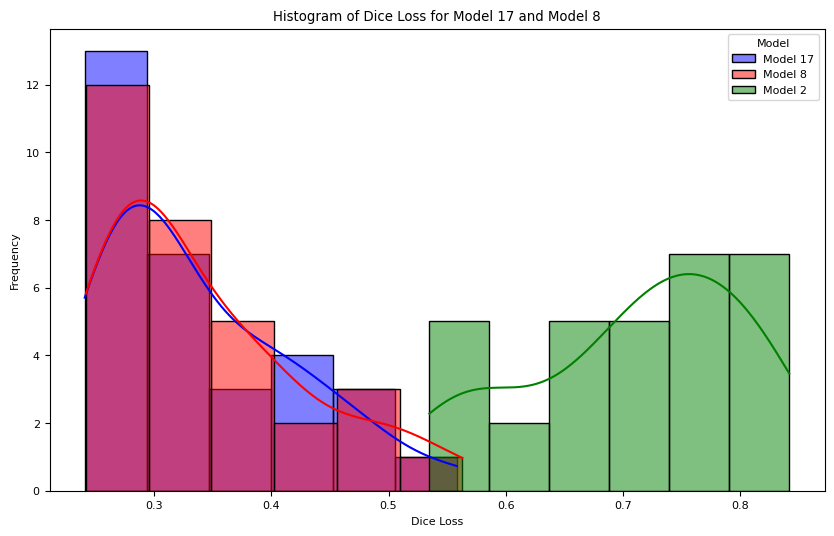

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter the DataFrame for the two models
df_filtered = df[df['Model'].isin(['unet_model_expandedmask_17_-leakyrelu-16-128features_best_model.pth', 
                                   'unet_model_expandedmask_8_best_model.pth',
                                   'unet_model_test_2_best_model.pth'])]

# Create overlapping histograms
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered[df_filtered['Model'] == 'unet_model_expandedmask_17_-leakyrelu-16-128features_best_model.pth']['Dice Loss'], 
             color='blue', kde=True, alpha=0.5, label='Model 17')
sns.histplot(df_filtered[df_filtered['Model'] == 'unet_model_expandedmask_8_best_model.pth']['Dice Loss'], 
             color='red', kde=True, alpha=0.5, label='Model 8')
sns.histplot(df_filtered[df_filtered['Model'] == 'unet_model_test_2_best_model.pth']['Dice Loss'], 
             color='green', kde=True, alpha=0.5, label='Model 2')
plt.legend(title='Model')
plt.title('Histogram of Dice Loss for Model 17 and Model 8')
plt.xlabel('Dice Loss')
plt.ylabel('Frequency')
plt.show()

In [62]:
medians.sort_values()

Model
unet_model_expandedmask_8_best_model.pth                                                      0.306631
unet_model_expandedmask_9_best_model.pth                                                      0.313011
unet_model_expandedmask_7_best_model.pth                                                      0.313074
unet_model_expandedmask_17_-leakyrelu-16-64features-sigmoid-256patch_best_model.pth           0.313402
unet_model_expandedmask_17_-leakyrelu-16-128features_best_model.pth                           0.314219
unet_model_expandedmask_17_-leakyrelu-4-128features-sigmoid-256patch_best_model.pth           0.316632
unet_model_expandedmask_17_-leakyrelu-32-256features_best_model.pth                           0.325075
unet_model_expandedmask_14_attention_best_model.pth                                           0.331201
unet_model_expandedmask_17_-leakyrelu-64-256features-scaledsigmoid-256patch_best_model.pth    0.341664
unet_model_expandedmask_13_best_model.pth                          